
0: 384x640 4 persons, 50.2ms
Speed: 2.0ms preprocess, 50.2ms inference, 91.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 23.5ms
Speed: 1.7ms preprocess, 23.5ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 25.6ms
Speed: 0.0ms preprocess, 25.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 26.1ms
Speed: 0.0ms preprocess, 26.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 25.2ms
Speed: 0.0ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 27.9ms
Speed: 0.0ms preprocess, 27.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 21.7ms
Speed: 5.7ms preprocess, 21.7ms inference, 1.0ms postprocess per image at shape 

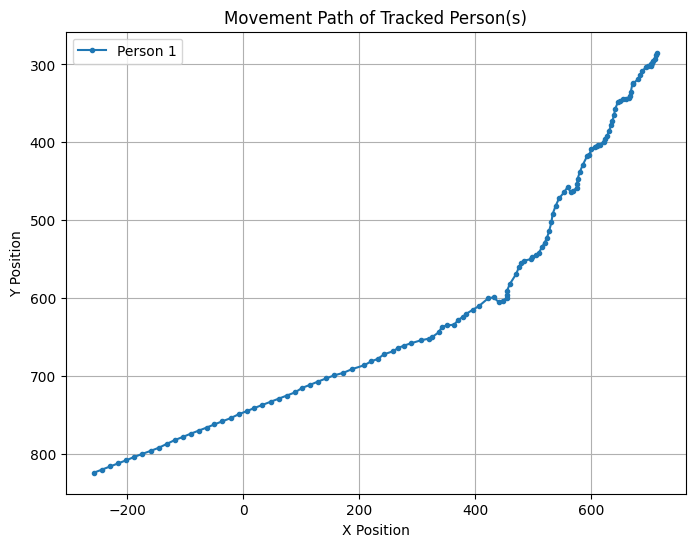

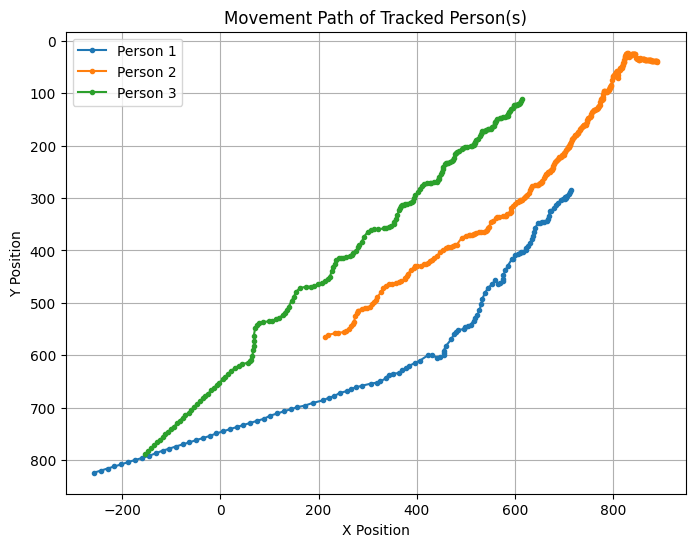

In [1]:
import cv2
import torch
import random
import argparse
import matplotlib.pyplot as plt
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort


class Opt:
    source = r"C:\Users\nisha\OneDrive\Desktop\ML Projects\Kalkini_Project\input_videos\test.mp4"  # Replace with your video file
    output = r"C:\Users\nisha\OneDrive\Desktop\ML Projects\Kalkini_Project\output_videos\test_output_medium_3.mp4"
    weights = r"C:\Users\nisha\OneDrive\Desktop\ML Projects\Kalkini_Project\models\yolov8m.pt"
    conf_thres = 0.5
    device = "cuda" if torch.cuda.is_available() else "cpu"

opt = Opt()

# Initialize YOLOv8 model & DeepSORT tracker
yolo_model = YOLO(opt.weights).to(opt.device)
tracker = DeepSort(max_age=30, n_init=3, nn_budget=100)

# Open video file
cap = cv2.VideoCapture(opt.source)
frame_width, frame_height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

# Set up video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(opt.output, fourcc, fps, (frame_width, frame_height))

# Track storage
id_map = {}  # Map DeepSORT track IDs to unique IDs
next_person_id = 1
track_history = {}  # Stores movement history
rand_color_list = {}  # Assigns random colors


def detect_people(frame):
    """Run YOLOv8 on the frame and return detections for persons only."""
    results = yolo_model(frame, conf=opt.conf_thres)
    detections = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            if cls == 0:  # Class '0' is 'person'
                detections.append(([x1, y1, x2 - x1, y2 - y1], conf, cls))
    return detections

def plot_person_movement(person_ids):
    """
    Visualizes the movement of the given person(s) using stored tracking data.

    :param person_ids: A single ID or a list of IDs to visualize.
    """
    plt.figure(figsize=(8, 6))

    # Ensure we handle single ID input
    if isinstance(person_ids, int):
        person_ids = [person_ids]

    for person_id in person_ids:
        if person_id in track_history:
            coords = track_history[person_id]
            xs, ys = zip(*coords)  # Separate x and y coordinates

            plt.plot(xs, ys, marker="o", linestyle="-",
                     label=f'Person {person_id}', markersize=3)

    plt.gca().invert_yaxis()  # Invert Y-axis to match video coordinates
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Movement Path of Tracked Person(s)")
    plt.legend()
    plt.grid()
    plt.show()

def update_tracks(detections, frame):
    """Update the DeepSORT tracker and assign unique IDs."""
    global next_person_id
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if track.is_confirmed():
            x, y, w, h = map(int, track.to_tlwh())
            track_id = track.track_id

            # Assign a persistent unique ID
            if track_id not in id_map:
                id_map[track_id] = next_person_id
                next_person_id += 1
            unique_id = id_map[track_id]

            # Assign color
            if unique_id not in rand_color_list:
                rand_color_list[unique_id] = (
                    random.randint(0, 255),
                    random.randint(0, 255),
                    random.randint(0, 255),
                )
            color = rand_color_list[unique_id]

            # Draw bounding box and ID
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f'ID {unique_id}', (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            # Store movement history
            if unique_id not in track_history:
                track_history[unique_id] = []
            track_history[unique_id].append((x + w // 2, y + h // 2))

            # Draw complete movement trail
            for i in range(1, len(track_history[unique_id])):
                cv2.line(frame, track_history[unique_id][i - 1],
                         track_history[unique_id][i], color, 2)
    
    return frame


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    detections = detect_people(frame)  # YOLO Detection
    frame = update_tracks(detections, frame)  # Update DeepSORT Tracker

    # Write and display frame
    out.write(frame)
    cv2.imshow('YOLOv8 + DeepSORT', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()
print(f'Output saved to {opt.output}')
plot_person_movement(1)  # Visualize person with ID 1
plot_person_movement([1, 2, 3])  # Compare movements of IDs 1, 2, and 3
